# Imports and Setup
To begin, run the cell(s) below to install the necessary setup and imports.

In [ ]:
!sudo apt install python3.8

In [ ]:
!python3.8 --version

Python 3.8.14


In [2]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2022-09-30 02:51:29--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2022-09-30 02:51:29--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 67.8M 1s
    50K .......... .......... .......... .......... ..........  0%

In [3]:
%%bash
conda install --channel defaults conda python=3.8 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs: 
    - conda
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ld_impl_linux-64-2.38      |       h1181459_1         732 KB
    xz-5.2.6                   |       h5eee18b_0         475 KB
    tqdm-4.64.1                |   py38h06a4308_0         122 KB
    toolz-0.11.2               |     pyhd3eb1b0_0          48 KB
    yaml-0.2.5                 |       h7b6447c_0          87 KB
    pysocks-1.7.1              |   py38h06a4308_0          31 KB
    conda-22.9.0               |   py38h06a4308_0         964 KB
    pycparser-2.21             |     pyhd3eb1b0_0          94 KB
    libffi-3.3                 |       he6710b0_2          54 KB
    pycosat-0.6.3              |   py38h7b6447c_1         107 KB
    ncurses-6.3                |       h5eee18b_3   

ld_impl_linux-64-2.3 |  732 KB | ########## | 100% 
xz-5.2.6             |  475 KB | ########## | 100% 
tqdm-4.64.1          |  122 KB | ########## | 100% 
toolz-0.11.2         |   48 KB | ########## | 100% 
yaml-0.2.5           |   87 KB | ########## | 100% 
pysocks-1.7.1        |   31 KB | ########## | 100% 
conda-22.9.0         |  964 KB | ########## | 100% 
pycparser-2.21       |   94 KB | ########## | 100% 
libffi-3.3           |   54 KB | ########## | 100% 
pycosat-0.6.3        |  107 KB | ########## | 100% 
ncurses-6.3          |  1.1 MB | ########## | 100% 
wheel-0.37.1         |   31 KB | ########## | 100% 
certifi-2022.9.14    |  158 KB | ########## | 100% 
tk-8.6.12            |  3.3 MB | ########## | 100% 
requests-2.28.1      |   92 KB | ########## | 100% 
pip-22.1.2           |  2.9 MB | ########## | 100% 
cffi-1.15.1          |  230 KB | ########## | 100% 
openssl-1.1.1q       |  3.8 MB | ########## | 100% 
readline-8.1.2       |  423 KB | ########## | 100% 
brotlipy-0.7

In [ ]:
!conda update -n base -c defaults conda --yes

Solving environment: \ | / - \ | / - \ | / - \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::six==1.11.0=py36h372c433_1
  - defaults/linux-64::chardet==3.0.4=py36h0f667ec_1
  - defaults/linux-64::asn1crypto==0.24.0=py36_0
| / - \ | done

# All requested packages already installed.

Retrieving notices: ...working... done


In [ ]:
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.8/site-packages"))

In [ ]:
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.8/site-packages']

In [ ]:
!conda init zsh

no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
modified      /root/.zshrc

==> For changes to take effect, close and re-open your current shell. <==



In [ ]:
!conda create --name env python=3.8 --yes

Solving environment: \ done

## Package Plan ##

  environment location: /usr/local/envs/env

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.07.19 |       h06a4308_0         124 KB
    certifi-2022.9.14          |   py38h06a4308_0         154 KB
    ld_impl_linux-64-2.38      |       h1181459_1         654 KB
    libffi-3.3                 |       he6710b0_2          50 KB
    libgcc-ng-11.2.0           |       h1234567_1         5.3 MB
    libstdcxx-ng-11.2.0        |       h1234567_1         4.7 MB
    ncurses-6.3                |       h5eee18b_3         781 KB
    openssl-1.1.1q             |       h7f8727e_0         2.5 MB
    pip-22.1.2                 |   py38h06a4308_0         2.5 MB
    python-3.8.13              |       h12debd9_0        18.8 MB
    readline-8.1.2             |       h7f8727e_1         354 KB
 

In [ ]:
!source /usr/local/bin/activate env

In [ ]:
%%bash
pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html
pip install timm==0.4.12
pip install pickle5
pip install scikit-learn
pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 GB 751.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 8.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py)

tcmalloc: large alloc 2137669632 bytes == 0x5631ad8c6000 @  0x7fddb95d71e7 0x5631aab32593 0x5631aab32620 0x5631aab84bcd 0x5631aab85988 0x5631aab92d15 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe37e7 0x5631aabece60 0x5631aabe2600 0x5631aabe3bc4 0x5631aabedeb0 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600
tcmalloc: large alloc 2672091136 bytes == 0x56322cf6a000 @  0x7fddb95d8615 0x5631aab84bcd 0x5631aab85988 0x5631aab92d15 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe2600 0x5631aabe3b64 0x5631aabece60 0x5631aabe37e7 0x5631aabece60 0x5631aabe2600 0x5631aabe3bc4 0x5631aabedeb0 0x5631aabe2600 0x5631aabe3b64 0x5631aabe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Toyota_Smarthome-main/pipline/

/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/pipline


In [ ]:
!python3.8 /content/drive/MyDrive/Toyota_Smarthome-main/pipline/train.py --help

usage: train.py
       [-h]
       [-mode MODE]
       [-train TRAIN]
       [-comp_info COMP_INFO]
       [-rgb_model_file RGB_MODEL_FILE]
       [-flow_model_file FLOW_MODEL_FILE]
       [-gpu GPU]
       [-dataset DATASET]
       [-rgb_root RGB_ROOT]
       [-flow_root FLOW_ROOT]
       [-type TYPE]
       [-lr LR]
       [-epoch EPOCH]
       [-model MODEL]
       [-APtype APTYPE]
       [-randomseed RANDOMSEED]
       [-load_model LOAD_MODEL]
       [-num_channel NUM_CHANNEL]
       [-batch_size BATCH_SIZE]
       [-kernelsize KERNELSIZE]
       [-feat FEAT]
       [-split_setting SPLIT_SETTING]

optional arguments:
  -h, --help
    show this
    help
    message and
    exit
  -mode MODE
    rgb or flow
    (or joint
    for eval)
  -train TRAIN
    train or
    eval
  -comp_info COMP_INFO
  -rgb_model_file RGB_MODEL_FILE
  -flow_model_file FLOW_MODEL_FILE
  -gpu GPU
  -dataset DATASET
  -rgb_root RGB_ROOT
  -flow_root FLOW_ROOT
  -type TYPE
  -lr LR
  -epoch EPOCH
  -model MODEL

In [ ]:
!python3.8 /content/drive/MyDrive/Toyota_Smarthome-main/pipline/train.py \
-dataset TSU \
-mode rgb \
-split_setting CS \
-model PDAN \
-num_channel 512 \
-lr 0.0002 \
-kernelsize 3 \
-APtype map \
-epoch 15 \
-batch_size 1 \
-comp_info TSU_CS_RGB_PDAN \
-load_model /content/drive/MyDrive/Toyota_Smarthome-main/model/PDAN_TSU_RGB \
-rgb_model_file P02T01C06

Random_SEED!!!: 0
PDAN
batch_size: 1
cuda_avail True
RGB mode ../feature_file/RGB_i3d_16frames_64000_SSD
Traceback (most recent call last):
  File "/content/drive/MyDrive/Toyota_Smarthome-main/pipline/train.py", line 295, in <module>
    dataloaders, datasets = load_data(train_split, test_split, rgb_root)
  File "/content/drive/MyDrive/Toyota_Smarthome-main/pipline/train.py", line 129, in load_data
    dataset = Dataset(train_split, 'training', root, batch_size, classes)
  File "/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/pipline/smarthome_i3d_per_video.py", line 59, in __init__
    self.data = make_dataset(split_file, split, root, classes)
  File "/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/pipline/smarthome_i3d_per_video.py", line 30, in make_dataset
    data = json.load(f)
  File "/usr/local/lib/python3.8/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/

In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.0/752.0 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.1/107.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.0/424.0 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

## Initializing Constants

In [ ]:
# INITIALIZING PATH VARIABLES (CHANGE HERE IF DIFFERENT DIRECTORY)

PATH_TO_MODEL_FOLDER = "/content/drive/MyDrive/Toyota_Smarthome-main/model/"
PATH_TO_VIDEO_FOLDER = "/content/drive/MyDrive/Toyota_Smarthome-main/video/"
PATH_TO_FEATURE_FOLDER = "/content/drive/MyDrive/Toyota_Smarthome-main/feature_file/"

# R2

Data Exploration Section:
- Check out the different input videos (with UI)
- See playback of video

In [ ]:
import os
import ipywidgets as widgets

videoList = os.listdir(PATH_TO_VIDEO_FOLDER)

video = widgets.Dropdown(
    options = videoList,
    description='Video:',
    disabled=False,
)
video

Dropdown(description='Video:', options=('sample_video_2.mp4', 'sample_video_1.mp4'), value='sample_video_2.mp4…

In [ ]:
from IPython.display import Video

VIDEO_SELECTED = PATH_TO_VIDEO_FOLDER + video.value
Video(VIDEO_SELECTED)

# R3
Inference Section:
- Load a pretrained model (with UI)
- Choose input video (with UI)
- See inference result in the form out output video with captions that indicte the current detected activity in each video frame

In [ ]:
import os
import ipywidgets as widgets

modelList = os.listdir(PATH_TO_MODEL_FOLDER)

model = widgets.Dropdown(
    options = modelList,
    description='Model:',
    disabled=False,
)

box = widgets.Box(children = [model, video])
box

Box(children=(Dropdown(description='Model:', options=('PDAN_TSU_RGB.value', '.ipynb_checkpoints'), value='PDAN…

In [ ]:
#finalized chosen model and video directory

SELECTED_MODEL = PATH_TO_MODEL_FOLDER + model.value
SELECTED_VIDEO = PATH_TO_VIDEO_FOLDER + video.value
print(SELECTED_MODEL)
print(SELECTED_VIDEO)

/content/drive/MyDrive/Colab Notebooks/ICT3104/Toyota_Smarthome-main/model/PDAN_TSU_RGB
/content/drive/MyDrive/Colab Notebooks/ICT3104/Toyota_Smarthome-main/video/sample_video_2.mp4


# FEATURE EXTRACTION

TSU I3D Feature Extraction from video

In [ ]:
%cd /content/drive/MyDrive/Toyota_Smarthome-main/feature_extract/

! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6 av==8.0.2

/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/feature_extract
Cloning into 'video_features'...
remote: Enumerating objects: 1283, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 1283 (delta 248), reused 298 (delta 203), pack-reused 899
Receiving objects: 100% (1283/1283), 288.54 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (664/664), done.
Checking out files: 100% (177/177), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/feature_extract


In [ ]:
%cd /content/drive/MyDrive/Toyota_Smarthome-main/feature_extract/video_features

/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/feature_extract/video_features


In [ ]:
from models.i3d.extract_i3d import ExtractI3D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

# TODO: RE-ADJUST THE DIRECTORY TO BE TO FEATURE_FILE

# TODO: RE-ADJUST TRAIN_CUSTOM.PY

In [ ]:
# Select the feature type
feature_type = 'i3d'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.video_paths = ['/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/videos/sample_videos/sample_video_1.mp4']
# args.show_pred = True
# args.stack_size = 24
# args.step_size = 24
# args.extraction_fps = 25
args.flow_type = 'raft' # 'pwc' is not supported on Google Colab (cupy version mismatch)
# args.streams = 'flow'

# Load the model
extractor = ExtractI3D(args)

# Extract features
for video_path in args.video_paths:
    # extract name of video from video path (and remove '.mp4' suffix)
    video_name = (video_path.split('/')[-1]).split('.')[0]
    print(video_name)
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    print(feature_dict.items())
    for k, v in feature_dict.items():
      print(k)
      print(v.shape)
      print(v)
      if k == "rgb":
        np.save(f'/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/extracted_features/rgb/{video_name}_rgb', v)
      elif k == "flow":
        np.save(f'/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/extracted_features/flow/{video_name}_flow', v)
      elif k == "fps":
        np.save(f'/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/extracted_features/fps/{video_name}_fps', v)
      elif k == "timestamps_ms":
        np.save(f'/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/extracted_features/timestamps_ms/{video_name}_timestamps_ms', v)
      else:
        raise NotImplementedError("Error: Unexpected item in feature_dict!")

In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/Toyota_Smarthome-main/pipline/data/extracted_features/rgb/sample_video_1_rgb.npy')
print(data)

# R4 

- Choose a dataset subfolder to use for training (with UI)
- Initialize a model with a network architecture configured in a separate .py file

In [ ]:
import os
import ipywidgets as widgets

featureFolder = os.listdir(PATH_TO_FEATURE_FOLDER)

feature = widgets.Dropdown(
    options = featureFolder,
    description='Feature:',
    disabled=False,
)
feature


Dropdown(description='Feature:', options=('RGB_i3d_16frames_64000_SSD',), value='RGB_i3d_16frames_64000_SSD')

In [ ]:
SELECTED_FEATURE = PATH_TO_FEATURE_FOLDER + feature.value
print(SELECTED_FEATURE)

/content/drive/MyDrive/Toyota_Smarthome-main/feature_file/RGB_i3d_16frames_64000_SSD


## Experiment

In [ ]:
!pip install pafy youtube-dl moviepy
!pip install imageio-ffmpeg
import os
import cv2
import math
import pafy
import imageio
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 50.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.6 MB/s 


In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#!unrar x UCF50.rar -inul -y

In [ ]:
%cd /content/drive/MyDrive/Toyota_Smarthome-main/video

/content/drive/.shortcut-targets-by-id/1LWR6jlRpEpJnHZO4yBjJ5EPNy1QfYCYq/Toyota_Smarthome-main/video


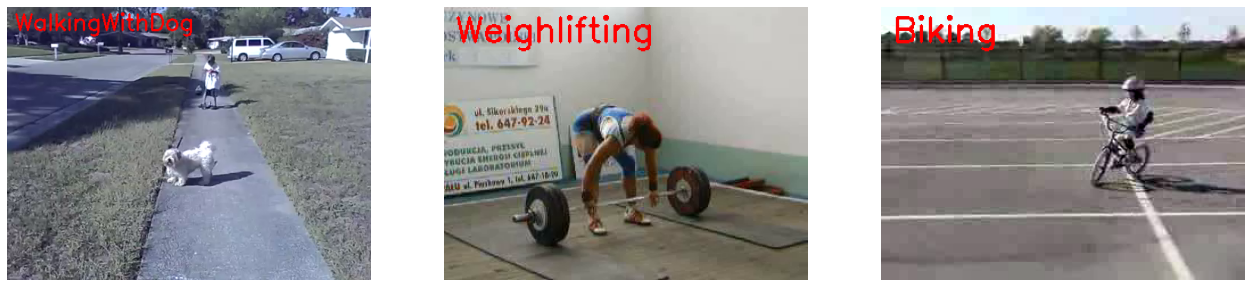

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('trainVideos')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 3)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'trainVideos/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'trainVideos/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 10 #if less videos in each class, need the change the number down

dataset_directory = "trainVideos"
classes_list = ["Biking","Weighlifting","WalkingWithDog"]

model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: Biking
Extracting Data of Class: Weighlifting
Extracting Data of Class: WalkingWithDog


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
5/5 [==============================] - 1s 51ms/step - loss: 0.4687 - accuracy: 0.7368 - val_loss: 1.1200 - val_accuracy: 0.2000
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5671 - accuracy: 0.7895 - val_loss: 1.1128 - val_accuracy: 0.2000
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 0.4935 - accuracy: 0.7895 - val_loss: 1.1229 - val_accuracy: 0.4000
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.4525 - accuracy: 0.8421 - val_loss: 1.1126 - val_accuracy: 0.4000
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.5164 - accuracy: 0.6842 - val_loss: 1.1021 - val_accuracy: 0.4000
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.2921 - accuracy: 0.8947 - val_loss: 1.0709 - val_accuracy: 0.6000
Epoch 7/50
5/5 [==============================] - 0s 11ms/step - loss: 0.1765 - accuracy: 0.9474 - val_loss: 1.0589 - val_accuracy: 0.6000
Epoch 8/50
5/5 [===========

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
model_name = f'captionModel_new2.h5'

# Saving your Model
model.save(model_name)

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        #normalized_frame = resized_frame / 255
        normalized_frame = resized_frame

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


    #     cv2.imshow('Predicted Frames', frame)

    #     key_pressed = cv2.waitKey(10)

    #     if key_pressed == ord('q'):
    #         break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = f'/content/drive/MyDrive/Toyota_Smarthome-main/video/output3.mp4'
input_video_file_path = f'/content/drive/MyDrive/Toyota_Smarthome-main/video/sample_video_2.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook

**Using Caption Model Staightway**

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/Toyota_Smarthome-main/video/captionModel_new.h5')

In [ ]:
image_height, image_width = 64, 64
classes_list = ["WalkingWithDog","Weighlifting"]
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 20

# Constructing The Output YouTube Video Path
output_video_file_path = f'/content/drive/MyDrive/Toyota_Smarthome-main/video/outputnew3.mp4'
input_video_file_path = f'/content/drive/MyDrive/Toyota_Smarthome-main/video/sample_video_1.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
